In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from jupyterthemes import jtplot
jtplot.style('oceans16')

%matplotlib inline

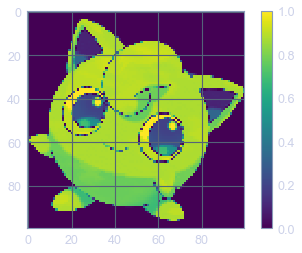

In [2]:
Im = mpimg.imread('jigglypuff.png')
Im = np.mean(Im[::5,::5,:2], axis=2)
plt.imshow(Im); plt.colorbar();

In [3]:
m = nn.Conv2d(1, 1, 5, 2, padding=2)

In [146]:
def pad_image(image):
    return Variable(torch.unsqueeze(torch.unsqueeze(torch.from_numpy(image), 0), 0))

n_channels = 32
target_size = [1, n_channels, Im.shape[0], Im.shape[1]]

In [147]:
im = pad_image(Im)

In [150]:
class generator(torch.nn.Module):
    def __init__(self, n_channels):
        super(generator, self).__init__()
        self.upscale = nn.ConvTranspose2d(n_channels, 1, 5, 5, padding=2)
    def forward(self, x):
        h = self.upscale(x, output_size=im.size())
        return h
    
class recognizer(torch.nn.Module):
    def __init__(self, n_channels):
        super(recognizer, self).__init__()
        self.downscale = nn.Conv2d(1, n_channels, 5, 5, padding=2)
    def forward(self, x):
        h = self.downscale(x)
        return h
    
G = generator(n_channels)
R = recognizer(n_channels)

In [151]:
m = nn.Conv2d(1 , n_channels, 5, 5, padding=2)
h = m(im)

In [152]:
# Reconstruction with larger receptive fields 
upscale = nn.ConvTranspose2d(n_channels, 1, 6, 5, padding=2)

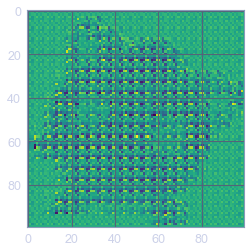

In [153]:
out = upscale(h, output_size=im.size())
plt.imshow(torch.squeeze(out).data.numpy())

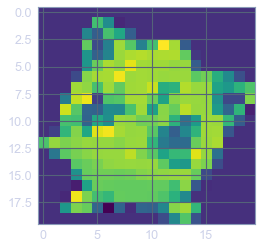

In [154]:
plt.imshow(torch.squeeze(h).data.numpy()[0,:,:])

In [175]:
G = generator(n_channels).cuda()
R = recognizer(n_channels).cuda()

Er = Variable(torch.zeros(im.size())).cuda()
y = Variable(torch.randn(h.size())).cuda()
optim = torch.optim.SGD(G.parameters(), lr=0.01)
optim2 = torch.optim.SGD(R.parameters(), lr=0.01)
for ind in range(1000):
    out = G(y)
    Er = (im.cuda() - out)
    y = F.tanh(R(Er.detach()))
    optim.zero_grad()
    optim2.zero_grad()
    loss = F.smooth_l1_loss(out, im.cuda())
#     loss = torch.mean(torch.pow(torch.squeeze(Er),2))
#     loss.backward(retain_graph=True)
    loss.backward()
    optim.step()
    optim2.step()

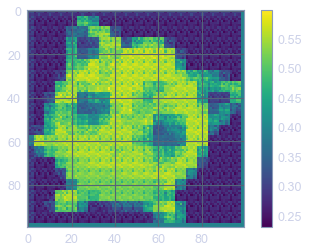

In [176]:
plt.imshow(torch.squeeze(out.cpu()).data.numpy()); plt.colorbar()

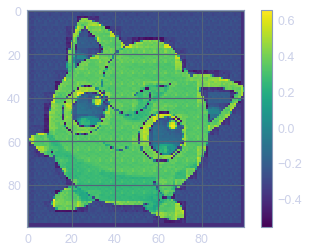

In [177]:
plt.imshow(torch.squeeze(Er.cpu()).data.numpy()); plt.colorbar()